# Your Average Sentiment Network (AvgNet) NLP model

Now, we try different nlp model as given in this paper [1][4], known as Your Average Sentiment Network (AvgNet).

## Data Pre-processing and Preparation

This paper [1,4] calculates the n-grams of an input sentence and append them to the end of a sentence. Here, we'll use bi-grams. Briefly, a bi-gram is a pair of words/tokens that appear consecutively within a sentence. 

For example, in the sentence "how are you ?", the bi-grams are: "how are", "are you" and "you ?".

The `generate_bigrams` function takes a sentence that has already been tokenized, calculates the bi-grams and appends them to the end of the tokenized list.

In [1]:
def generate_bigrams(x):
    n_grams = set(zip(*[x[i:] for i in range(2)]))
    for n_gram in n_grams:
        x.append(' '.join(n_gram))
    return x

In [3]:
import torch
from torchtext import data
from torchtext import datasets

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy', preprocessing = generate_bigrams)
LABEL = data.LabelField()#dtype = torch.float)


fields = [(None, None), ('label',LABEL ), (None, None), ('text', TEXT)]

train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = 'data',
                                        train = 'three_tweets.csv',
                                        validation = 'three_tweets.csv',
                                        test = 'three_tweets1.csv',
                                        format = 'csv',
                                        skip_header = True,
                                        fields = fields)


As before, we load the IMDb dataset and create the splits.

In [5]:
import random

train_data, valid_data = train_data.split(0.975,0.025,random_state = random.seed(SEED))

print('Total training examples:', len(train_data))
print('Total validation examples: ',len(valid_data))
print('Total testing examples: ',len(test_data))

#train_data, test_data = IMDB.splits(TEXT, LABEL)

#train_data, valid_data = train_data.split(random_state = random.seed(SEED))

Total training examples: 39000
Total validation examples:  1000
Total testing examples:  40000


Build the vocab and load the pre-trained word embeddings.

In [6]:
MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)


#TEXT.build_vocab(train_data)
#LABEL.build_vocab(train_data)



And create the iterators.

In [7]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    sort = False, #don't sort test/validation data
    batch_size=BATCH_SIZE,
    device=device)

#train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
 #   (train_data, valid_data, test_data), 
  #  batch_size = BATCH_SIZE, 
   # device = device)

## Designing the deep NLP Model

Next, we define the deep NLP model as given in the paper ().

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class NLPModel1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        self.fc = nn.Linear(embedding_dim, output_dim)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        embedded = self.embedding(text)
                
        #embedded = [sent len, batch size, emb dim]
        
        embedded = embedded.permute(1, 0, 2)
        
        #embedded = [batch size, sent len, emb dim]
        
        pooled = F.avg_pool2d(embedded, (embedded.shape[1], 1)).squeeze(1) 
        
        #pooled = [batch size, embedding_dim]
                
        return self.fc(pooled)

Next, we make the instance of our NLPModel1 class.

In [20]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
OUTPUT_DIM = 3
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = NLPModel1(INPUT_DIM, EMBEDDING_DIM, OUTPUT_DIM, PAD_IDX)

Looking at the number of parameters in our model:

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('The model has ',str(count_parameters(model)),'trainable parameters')

The model has  2500503 trainable parameters


And copy the pre-trained vectors to our embedding layer.

In [22]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [ 0.3847,  0.4935,  0.4910,  ...,  0.0263,  0.3905,  0.5222],
        ...,
        [-1.2269,  0.9161,  0.2021,  ..., -1.3261, -0.1917, -0.8085],
        [ 0.3921,  0.2244,  0.1675,  ..., -1.1015, -2.4818, -0.2673],
        [-0.7203,  0.0229,  0.4720,  ..., -1.8308,  0.7428,  1.3253]])

Not forgetting to zero the initial weights of our unknown and padding tokens.

In [23]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

## Train the Model

In [24]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

We define the criterion and place the model and criterion on the GPU (if available)...

In [25]:
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

We implement the function to calculate accuracy...

In [26]:

#util funtions
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]])

We define a function for training our model...

In [28]:
train_loss_values=[]
train_acc_values=[]


def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text)
        
        loss = criterion(predictions, batch.label)
        
        acc = categorical_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

print(LABEL.vocab.stoi)

defaultdict(None, {'unpleasant': 0, 'neutral': 1, 'pleasant': 2})


We define a function for testing our model...

In [68]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text)
            
            loss = criterion(predictions, batch.label)
            
            acc = categorical_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


from sklearn.metrics import precision_score,recall_score
precision=[]

def evaluate_test(model, iterator, criterion):
    
    
    import csv

    epoch_loss = 0
    epoch_acc = 0
    epoch_prec = 0
    epoch_recall = 0
    
    g=0
    model.eval()
    #sssssssss
    with torch.no_grad():
    
        for batch in iterator:
            g=g+1
            predictions = model(batch.text).squeeze(1)
            max_preds = predictions.argmax(dim = 1, keepdim = True) # get the index of the max probability

            epoch_prec+=precision_score(batch.label, max_preds, average='weighted')  
            epoch_recall+=recall_score(batch.label, max_preds, average='weighted')  

            #precision_score(y_true, y_pred, average='micro')  

            #precision_score(y_true, y_pred, average='weighted')
            
            #print(predictions)
            #print(batch.text.shape)
            #print(TEXT.vocab.itos[11])
            
            loss = criterion(predictions, batch.label)
            
            acc = categorical_accuracy(predictions, batch.label)
            #print(epoch_prec)
            #print(rounded_preds_us)
            #usman:check valid later
            
            with open('sentiment_results_model1_tweets.csv', mode='a') as sent_file:
                file_writer = csv.writer(sent_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                
                for x in range(0,len(predictions)):
                    file_writer.writerow([max_preds[x].item(),batch.label[x].item()])

            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    #print('g=',str(g)) 
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_prec / len(iterator), epoch_recall / len(iterator)


As before, we'll implement a useful function to tell us how long an epoch takes.

In [33]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our model.

In [82]:
N_EPOCHS = 25


train_loss_values=[]
train_acc_values=[]

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    #valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    train_loss_values.append(train_loss)    
    train_acc_values.append(train_acc)

    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    #if valid_loss < best_valid_loss:
    #best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'fastModel1Tweets.pt')
   
    print('Epoch: ',str(epoch+1),' | Epoch Time:',str(epoch_mins),'m ',str(epoch_secs),'s')
    print('\tTrain Loss: ',str(train_loss),' | Train Acc: ',str(train_acc*100),'%')
    #print('\t Val. Loss: ',str(valid_loss),' |  Val. Acc: ',str(valid_acc*100),'%')

Epoch:  1  | Epoch Time: 0 m  19 s
	Train Loss:  0.7897287846588698  | Train Acc:  66.40710382187953 %
Epoch:  2  | Epoch Time: 0 m  19 s
	Train Loss:  0.744459928059187  | Train Acc:  68.99931693663362 %
Epoch:  3  | Epoch Time: 0 m  20 s
	Train Loss:  0.7031527044343167  | Train Acc:  71.37380464155166 %
Epoch:  4  | Epoch Time: 0 m  21 s
	Train Loss:  0.6638762415921102  | Train Acc:  73.15488388303851 %
Epoch:  5  | Epoch Time: 0 m  18 s
	Train Loss:  0.6277147185607035  | Train Acc:  74.90181011254671 %
Epoch:  6  | Epoch Time: 0 m  18 s
	Train Loss:  0.5937983375103747  | Train Acc:  76.63165983606557 %
Epoch:  7  | Epoch Time: 0 m  18 s
	Train Loss:  0.561702800871896  | Train Acc:  77.97301912894015 %
Epoch:  8  | Epoch Time: 0 m  18 s
	Train Loss:  0.5327338378448956  | Train Acc:  79.3092554612238 %
Epoch:  9  | Epoch Time: 0 m  18 s
	Train Loss:  0.5058093271783141  | Train Acc:  80.70099044041555 %
Epoch:  10  | Epoch Time: 0 m  18 s
	Train Loss:  0.48008353109242485  | Tra

In [83]:
print(len(train_loss_values))
print(train_loss_values)
print(len(train_acc_values))
print(train_acc_values)

with open('the_model1_performance_tweets.txt', 'w') as filehandle:
    tLoss=','.join([str(x) for x in train_loss_values])
    filehandle.write(tLoss+"\n")
    tLoss=','.join([str(x) for x in train_acc_values])
    filehandle.write(tLoss)
    
    
    #for listitem in train_loss_values:
     #   filehandle.write(listitem)




25
[0.7897287846588698, 0.744459928059187, 0.7031527044343167, 0.6638762415921102, 0.6277147185607035, 0.5937983375103747, 0.561702800871896, 0.5327338378448956, 0.5058093271783141, 0.48008353109242485, 0.45651050390767267, 0.43421742598541446, 0.4127635674398453, 0.39359320788109886, 0.3746121198916044, 0.3577979523383203, 0.3417392050633665, 0.325904862484971, 0.3115832062163314, 0.2976689750298125, 0.28457477664361236, 0.27183057846593073, 0.26020720962618216, 0.24977997402187255, 0.23871020407217447]
25
[0.6640710382187953, 0.6899931693663363, 0.7137380464155166, 0.731548838830385, 0.7490181011254671, 0.7663165983606557, 0.7797301912894015, 0.7930925546122379, 0.8070099044041555, 0.8185792349401068, 0.8297984972351887, 0.8387892759237133, 0.8495901639344262, 0.8562243852459016, 0.8657189207975982, 0.8737875683385817, 0.8802851775630576, 0.8876109972351888, 0.8930242486664506, 0.8982752732566146, 0.9043118169073199, 0.9097762978467785, 0.9140368852459017, 0.9180840163934426, 0.92288

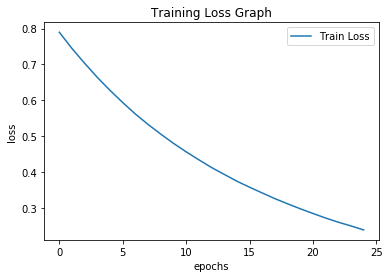

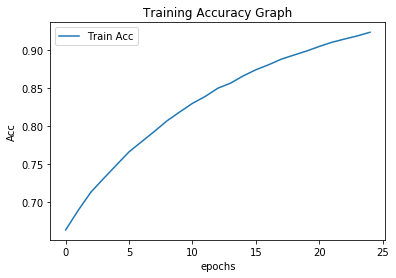

In [84]:
from matplotlib import pyplot as plt


train_loss_values=[]
train_acc_values=[]


# open file and read the content in a list
with open('the_model1_performance_tweets.txt', 'r') as filehandle:
    filecontents = filehandle.readlines()
    
    train_loss_values=[float(i) for i in filecontents[0].split(',')]
    train_acc_values=[float(i) for i in filecontents[1].split(',')]

plt.title('Training Loss Graph')
plt.plot(train_loss_values,label='Train Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


plt.title('Training Accuracy Graph')
plt.plot(train_acc_values,label='Train Acc')
plt.xlabel('epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()


The results are comparable to the results in the last notebook, but training takes considerably less time!

In [85]:
model.load_state_dict(torch.load('fastModel1Tweets.pt'))

import csv

with open('sentiment_results_model1_tweets.csv', mode='w') as sent_file:
    file_writer = csv.writer(sent_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    file_writer.writerow(['Our Prediction', 'Ground Truth (unpleasant: 0, neutral: 1, pleasant: 2)'])                
    

test_loss, test_acc, test_prec, test_recall = evaluate_test(model, test_iterator, criterion)

print('Test Loss: ',str(test_loss),' | Acc:',str(test_acc*100),'% ', 'Precision: ',str(test_prec), 'Recall: ',str(test_recall))
print('Results are also written in the csv file')

Test Loss:  0.25693694143295287  | Acc: 92.51 %  Precision:  0.9289378573952434 Recall:  0.9251
Results are also written in the csv file


## Now generating word cloud.

In [86]:
model_df1 = pd.read_csv ("./three_tweets1.csv")
model_df1.head()

,tweet_id,sentiment,author,content
0,1956967341,neutral,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,unpleasant,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,unpleasant,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,pleasant,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


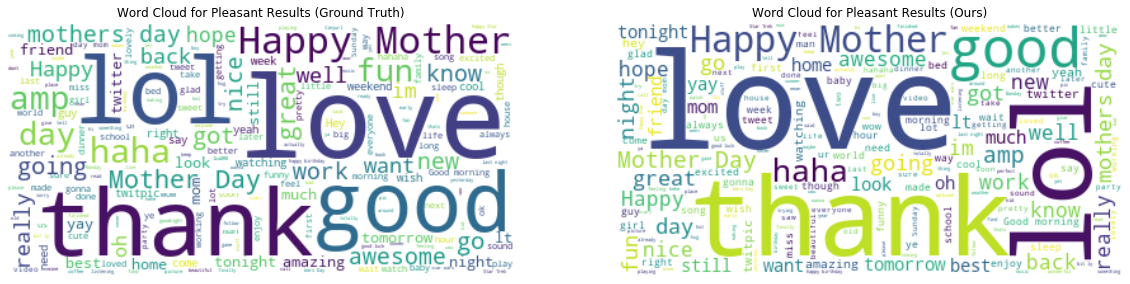

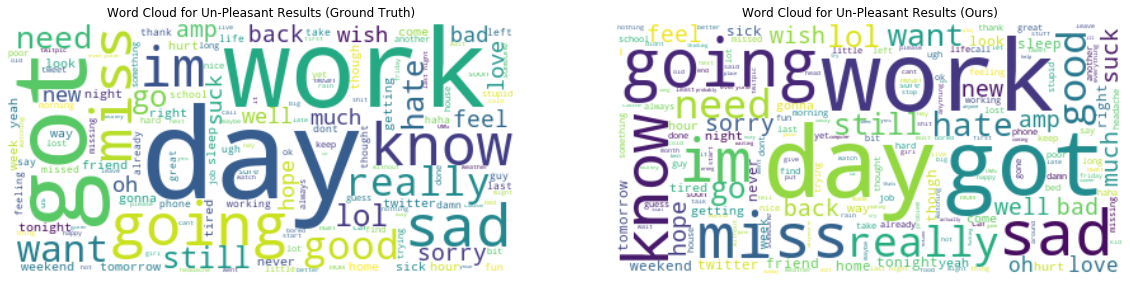

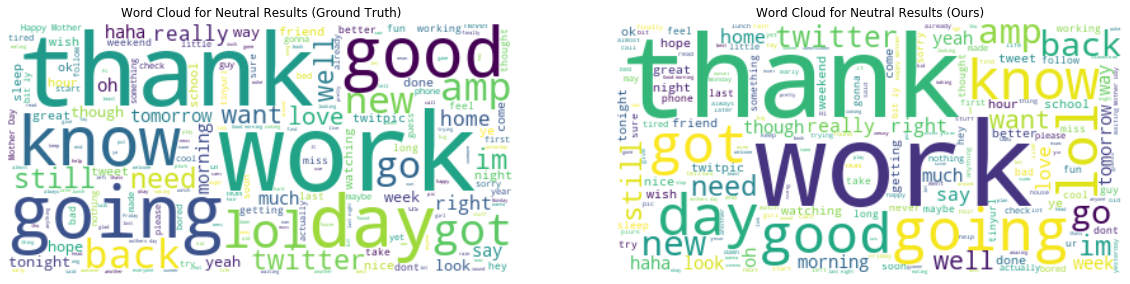

In [87]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pandas as pd

my_directory='./aclImdb'
stpwords = set(STOPWORDS)# removing the stop words.
stpwords.update(['movie','movies','film','films',
                 'actor','actress','cinema','even','scene','will','people','many','now','quot','today',
                 'story','br','role','dramas','drama','one','make','see','time','show','think','thing',
                 'characters','character','director'])# removing the words that are of no importance.

model_df = pd.read_csv ("./sentiment_results_model1_tweets.csv")

#POSITIVE

allTextPos=""
allTextPosGT=""

for ind in model_df.index: 
     if model_df['Ground Truth (unpleasant: 0, neutral: 1, pleasant: 2)'][ind]==2.0:
         allTextPosGT=allTextPosGT+" "+model_df1['content'][ind]

     if model_df['Our Prediction'][ind]==2.0:
         allTextPos=allTextPos+" "+model_df1['content'][ind]

     

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextPosGT)

# Display the generated image:
plt.title('Word Cloud for Pleasant Results (Ground Truth)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.show()


plt.subplot(1, 2, 2)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextPos)

# Display the generated image:
plt.title('Word Cloud for Pleasant Results (Ours)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

for ind in model_df.index: 
     if model_df['Ground Truth (unpleasant: 0, neutral: 1, pleasant: 2)'][ind]==2.0:
         allTextPosGT=allTextPosGT+" "+model_df1['content'][ind]

     if model_df['Our Prediction'][ind]==2.0:
         allTextPos=allTextPos+" "+model_df1['content'][ind]


#NEGATIVE

allTextNeg=""
allTextNegGT=""

for ind in model_df.index: 
     if model_df['Ground Truth (unpleasant: 0, neutral: 1, pleasant: 2)'][ind]==0.0:
         allTextNegGT=allTextNegGT+" "+model_df1['content'][ind]

     if model_df['Our Prediction'][ind]==0.0:
         allTextNeg=allTextNeg+" "+model_df1['content'][ind]


plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextNegGT)

# Display the generated image:
plt.title('Word Cloud for Un-Pleasant Results (Ground Truth)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.show()


plt.subplot(1, 2, 2)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextNeg)

# Display the generated image:
plt.title('Word Cloud for Un-Pleasant Results (Ours)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



# NEUTRAL

allTextNeutral=""
allTextNeutralGT=""

for ind in model_df.index: 
     if model_df['Ground Truth (unpleasant: 0, neutral: 1, pleasant: 2)'][ind]==1.0:
         allTextNeutralGT=allTextNeutralGT+" "+model_df1['content'][ind]

     if model_df['Our Prediction'][ind]==1.0:
         allTextNeutral=allTextNeutral+" "+model_df1['content'][ind]


plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextNeutralGT)

# Display the generated image:
plt.title('Word Cloud for Neutral Results (Ground Truth)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.show()


plt.subplot(1, 2, 2)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextNeutral)

# Display the generated image:
plt.title('Word Cloud for Neutral Results (Ours)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



## References

[1] https://arxiv.org/pdf/1607.01759.pdf

[2] https://arxiv.org/pdf/1408.5882.pdf

[3] https://ai.stanford.edu/~amaas/data/sentiment/

[4] https://github.com/bentrevett/pytorch-sentiment-analysis

[5] https://github.com/tlkh/text-emotion-classification